# Prime Trade AI Task 1

1. Setups and Imports

In [1]:
!pip install gdown -q

import gdown
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import classification_report, roc_auc_score, mean_squared_error, r2_score
import scipy.stats as stats
import warnings

warnings.filterwarnings('ignore')
sns.set(style='whitegrid')


2. Download Files

In [2]:
# Google Drive file IDs
hyperliquid_id = "1IAfLZwu6rJzyWKgBToqwSmmVYU6VbjVs"   # Historical data file id
feargreed_id   = "1PgQC0tO8XN-wqkNyghWc_-mnrYv_nhSf"   # Fear/Greed index file id

# Download files
gdown.download(f"https://drive.google.com/uc?id={hyperliquid_id}", "historical.csv", quiet=False)
gdown.download(f"https://drive.google.com/uc?id={feargreed_id}", "feargreed.csv", quiet=False)


Downloading...
From: https://drive.google.com/uc?id=1IAfLZwu6rJzyWKgBToqwSmmVYU6VbjVs
To: /content/historical.csv
100%|██████████| 47.5M/47.5M [00:00<00:00, 148MB/s]
Downloading...
From: https://drive.google.com/uc?id=1PgQC0tO8XN-wqkNyghWc_-mnrYv_nhSf
To: /content/feargreed.csv
100%|██████████| 90.8k/90.8k [00:00<00:00, 52.4MB/s]


'feargreed.csv'

3. Read CSVs

In [3]:
df_trades = pd.read_csv("historical.csv")
df_fg     = pd.read_csv("feargreed.csv")

print("Raw shapes:", df_trades.shape, df_fg.shape)

Raw shapes: (211224, 16) (2644, 4)


4. Standardize Column Names

In [4]:
def clean_cols(df):
    df.columns = (
        df.columns.str.strip()
        .str.lower()
        .str.replace(' ', '_')
        .str.replace('%','pct')
        .str.replace('-','_')
    )
    return df

df_trades = clean_cols(df_trades)
df_fg     = clean_cols(df_fg)

print("Trade cols:", df_trades.columns.tolist())
print("FG cols   :", df_fg.columns.tolist())

Trade cols: ['account', 'coin', 'execution_price', 'size_tokens', 'size_usd', 'side', 'timestamp_ist', 'start_position', 'direction', 'closed_pnl', 'transaction_hash', 'order_id', 'crossed', 'fee', 'trade_id', 'timestamp']
FG cols   : ['timestamp', 'value', 'classification', 'date']


5. Parse Timestamps

In [5]:
ts_col = None
for cand in ['timestamp_ist','timestamp','timestamp_utc','time','timestamplist']:
    if cand in df_trades.columns:
        ts_col = cand
        break

if ts_col is None:
    raise ValueError("No timestamp column found in trades dataset.")

df_trades[ts_col] = pd.to_datetime(df_trades[ts_col], errors='coerce')
df_trades['date'] = df_trades[ts_col].dt.date
df_fg['date'] = pd.to_datetime(df_fg['date'], errors='coerce').dt.date

df_trades = df_trades[~df_trades[ts_col].isna()].copy()

6. Feature Engineering

In [6]:
num_map = {}
for col in df_trades.columns:
    if 'closed' in col.lower() and 'pnl' in col.lower():
        num_map[col] = 'closed_pnl'
    if 'execution' in col and 'price' in col:
        num_map[col] = 'execution_price'
    if 'size_usd' in col:
        num_map[col] = 'size_usd'
    if 'size_tokens' in col:
        num_map[col] = 'size_tokens'

df_trades = df_trades.rename(columns=num_map)

if 'execution_price' in df_trades.columns:
    df_trades['execution_price'] = pd.to_numeric(df_trades['execution_price'], errors='coerce')
if 'size_usd' in df_trades.columns:
    df_trades['size_usd'] = pd.to_numeric(df_trades['size_usd'], errors='coerce')
if 'size_tokens' in df_trades.columns:
    df_trades['size_tokens'] = pd.to_numeric(df_trades['size_tokens'], errors='coerce')
if 'closed_pnl' in df_trades.columns:
    df_trades['closed_pnl'] = pd.to_numeric(df_trades['closed_pnl'], errors='coerce')

if 'size_usd' in df_trades.columns and df_trades['size_usd'].notna().sum() > 0:
    df_trades['notional'] = df_trades['size_usd']
else:
    df_trades['notional'] = df_trades['size_tokens'] * df_trades['execution_price']

df_trades['is_profitable'] = (df_trades['closed_pnl'] > 0).astype(int)
df_trades['pnl_pct'] = df_trades['closed_pnl'] / (df_trades['notional'] + 1e-9)

if 'side' in df_trades.columns:
    df_trades['side'] = df_trades['side'].astype(str).str.lower()
    le_side = LabelEncoder()
    df_trades['side_enc'] = le_side.fit_transform(df_trades['side'].fillna('unknown'))
else:
    df_trades['side_enc'] = 0

display(df_trades[['date','execution_price','size_usd','size_tokens','notional','closed_pnl','is_profitable','pnl_pct']].head())

,date,execution_price,size_usd,size_tokens,notional,closed_pnl,is_profitable,pnl_pct
0,2024-02-12,7.9769,7872.16,986.87,7872.16,0.0,0,0.0
1,2024-02-12,7.9800,127.68,16.00,127.68,0.0,0,0.0
2,2024-02-12,7.9855,1150.63,144.09,1150.63,0.0,0,0.0
3,2024-02-12,7.9874,1142.04,142.98,1142.04,0.0,0,0.0
4,2024-02-12,7.9894,69.75,8.73,69.75,0.0,0,0.0


7. Daily Aggregation

In [8]:
agg_funcs = {
    'closed_pnl': ['sum','mean','std'],
    'is_profitable': 'mean',
    'pnl_pct': ['mean','std'],
    'notional': 'sum'
}

df_day = df_trades.groupby('date').agg(agg_funcs)
df_day.columns = ['_'.join(col).strip() for col in df_day.columns.values]
df_day.reset_index(inplace=True)

8. Merge Code

In [9]:
fg_class_col = None
for c in df_fg.columns:
    if 'class' in c:
        fg_class_col = c

value_col = None
for c in df_fg.columns:
    if c not in [fg_class_col,'date'] and df_fg[c].dtype in [int,float]:
        value_col = c

df_day = df_day.merge(df_fg[['date', fg_class_col, value_col]].drop_duplicates(), on='date', how='left')

if fg_class_col:
    df_day[fg_class_col] = df_day[fg_class_col].astype('category')

display(df_day.head())

,date,closed_pnl_sum,closed_pnl_mean,closed_pnl_std,is_profitable_mean,pnl_pct_mean,pnl_pct_std,notional_sum,classification,value
0,2023-01-05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,477.00,Fear,29.0
1,2023-05-12,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,50005.83,Neutral,49.0
2,2024-01-01,-129.531460,-7.196192,85.847769,0.055556,-0.001354,0.003441,264239.53,Greed,65.0
3,2024-01-02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2008.18,Greed,71.0
4,2024-01-03,8244.241409,60.176945,111.958609,0.934307,0.032566,0.010461,472974.70,Greed,70.0


9. Exploratory Analysis

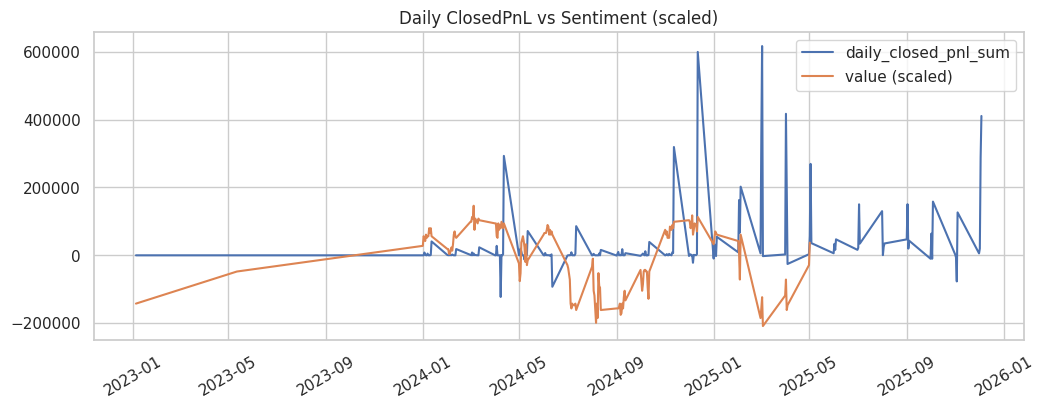

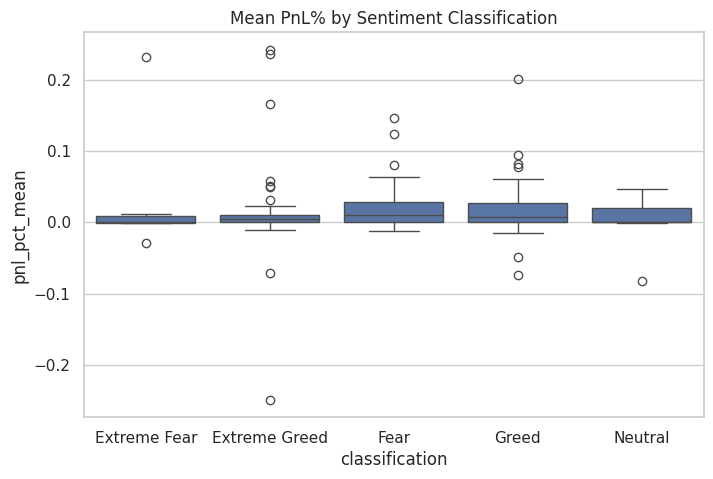

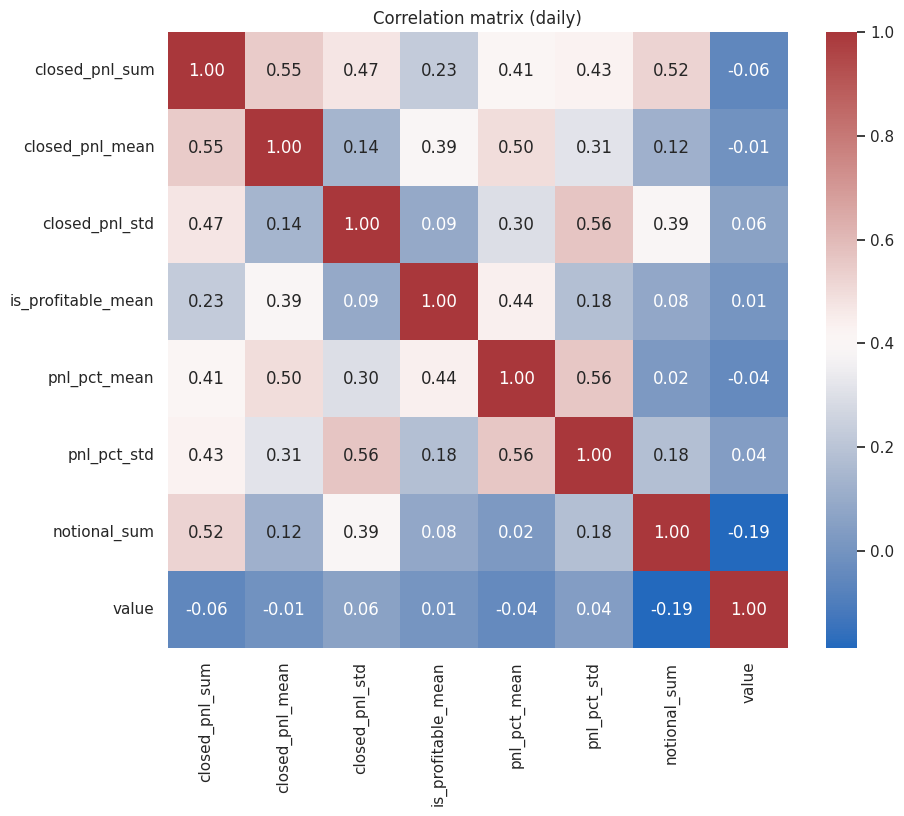

In [10]:
plt.figure(figsize=(12,4))
plt.plot(df_day['date'], df_day['closed_pnl_sum'], label='daily_closed_pnl_sum')

if value_col:
    s = df_day[value_col]
    s_scaled = (s - s.mean()) * (df_day['closed_pnl_sum'].std() / (s.std() + 1e-9))
    plt.plot(df_day['date'], s_scaled, label=f'{value_col} (scaled)')

plt.legend()
plt.title("Daily ClosedPnL vs Sentiment (scaled)")
plt.xticks(rotation=30)
plt.show()

if fg_class_col and 'pnl_pct_mean' in df_day.columns:
    plt.figure(figsize=(8,5))
    sns.boxplot(x=fg_class_col, y='pnl_pct_mean', data=df_day)
    plt.title("Mean PnL% by Sentiment Classification")
    plt.show()

plt.figure(figsize=(10,8))
num_cols = df_day.select_dtypes(include='number').columns
sns.heatmap(df_day[num_cols].corr(), annot=True, fmt=".2f", cmap='vlag')
plt.title("Correlation matrix (daily)")
plt.show()

10. Statistical Test

In [11]:
if fg_class_col and 'pnl_pct_mean' in df_day.columns:
    groups = [g['pnl_pct_mean'].dropna().values for n,g in df_day.groupby(fg_class_col)]
    if len(groups) > 1:
        stat, p = stats.kruskal(*groups)
        print(f"Kruskal-Wallis stat={stat:.4f}  p={p:.4f}")
        if p < 0.05:
            print("Significant difference between groups.")
        else:
            print("No significant difference detected.")
    else:
        print("Not enough sentiment groups for statistical test.")
else:
    print("Skipping Kruskal test — missing sentiment/class or pnl_pct_mean.")


Kruskal-Wallis stat=3.7664  p=0.4385
No significant difference detected.


11. Classification Model

In [12]:
features = []
if 'size_usd' in df_trades.columns:
    features.append('size_usd')
if 'execution_price' in df_trades.columns:
    features.append('execution_price')
features += ['notional','side_enc']

features = [f for f in features if f in df_trades.columns]
X = df_trades[features].fillna(0)
y = df_trades['is_profitable'].fillna(0).astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s  = scaler.transform(X_test)

clf = RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=42)
clf.fit(X_train_s, y_train)

y_pred = clf.predict(X_test_s)
print("Classification report:\n", classification_report(y_test, y_pred))

try:
    print("ROC AUC:", roc_auc_score(y_test, clf.predict_proba(X_test_s)[:,1]))
except:
    pass

importances = pd.Series(clf.feature_importances_, index=features).sort_values(ascending=False)
display(importances)

Classification report:
               precision    recall  f1-score   support

           0       0.87      0.90      0.89      9153
           1       0.86      0.82      0.84      6692

    accuracy                           0.87     15845
   macro avg       0.86      0.86      0.86     15845
weighted avg       0.87      0.87      0.87     15845

ROC AUC: 0.9418099945216372


,0
execution_price,0.513625
notional,0.190982
size_usd,0.190447
side_enc,0.104946


12. Regression Model

In [13]:
reg_features = features.copy()

if 'closed_pnl' in df_trades.columns:
    Xr = df_trades[reg_features].fillna(0)
    yr = df_trades['closed_pnl'].fillna(0)

    Xr_train, Xr_test, yr_train, yr_test = train_test_split(Xr, yr, test_size=0.2, random_state=42)

    scaler_r = StandardScaler()
    Xr_train_s = scaler_r.fit_transform(Xr_train)
    Xr_test_s  = scaler_r.transform(Xr_test)

    rfr = RandomForestRegressor(n_estimators=200, random_state=42)
    rfr.fit(Xr_train_s, yr_train)

    yr_pred = rfr.predict(Xr_test_s)

    print("Regression RMSE:", np.sqrt(mean_squared_error(yr_test, yr_pred)))
    print("Regression R2:", r2_score(yr_test, yr_pred))

    imp_r = pd.Series(rfr.feature_importances_, index=reg_features).sort_values(ascending=False)
    display(imp_r)
else:
    print("No closed_pnl column for regression.")

Regression RMSE: 1074.0909045067276
Regression R2: 0.15290625063565566


,0
execution_price,0.394661
notional,0.290925
size_usd,0.277329
side_enc,0.037085


13. Save Outputs

In [14]:
df_day.to_csv("daily_aggregates_with_sentiment.csv", index=False)
df_trades.to_csv("processed_trades.csv", index=False)

print("Saved: daily_aggregates_with_sentiment.csv  processed_trades.csv")

Saved: daily_aggregates_with_sentiment.csv  processed_trades.csv
